# How can I compare different models that predict the probability of defaulting on a loan?

In [ ]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

## Introduction (5 mts)

**Business Context.** Traditional commercial banks typically did not rely on statistical modeling to decide whether personal loans should be issued, although this is changing rapidly nowadays. You are a data scientist working in a modern commercial bank. Your data science team has already built simple regression models for predicting the probability that those loans would be defaulted on. However, you have noticed that many of these models perform much worse in production than they do in testing.

**Business Problem.** Your task is to **build a default probability model that you feel comfortable putting into production.**

**Analytical Context.** The dataset contains the details of 5000 loans requests that have been previously issued by your bank. For each loan, the final status of the loan (i.e. whether the loan defaulted) is also available:

1. The file **"loan_light.csv"** contains the details of 5000 loans
2. The file **"loan_param.xlsx"** contains the description of each covariate

The case will proceed as follows: you will 1) perform some data exploration to determine the appropriate variable transformations to make; 2) fit some simple models; 3) learn about **cross-validation** and use this to select the best simple model; and finally 4) responsibly construct more complex models using cross-validation.

## Data exploration (40 mts)

Let's start by taking a look at the data:

In [ ]:
Data = pd.read_csv("/content/loan_light.csv")
Data = Data.sample(frac=1)  #shuffle the rows

In [ ]:
print(Data.shape)
Data.head()

(5000, 21)


,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
2790,38000.0,Individual,2375.0,0.0,0.0,12.19,1,C,1.0,601.36,17100,5.0,0.0,OWN,36,0.0,0.0,debt_consolidation,2017,1,other
1822,55000.0,Joint App,20371.0,0.0,0.0,21.19,1,C,1.0,586.45,17500,4.0,0.0,MORTGAGE,36,2.0,0.0,credit_card,2017,0,professor
2857,45000.0,Individual,2437.0,0.0,0.0,17.09,10,A,0.0,308.64,10000,2.0,0.0,RENT,36,0.0,0.0,credit_card,2016,0,teacher
4776,125000.0,Individual,10340.0,0.0,2.0,14.10,1,D,4.0,874.93,35000,2.0,0.0,MORTGAGE,60,3.0,0.0,debt_consolidation,2015,0,manager
4482,70000.0,Individual,2089.0,0.0,0.0,9.12,3,C,0.0,848.27,25000,4.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,0,other


In [ ]:
Data.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [ ]:
df_description = pd.read_excel('loan_param.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


In [ ]:
Data.dtypes

annual_inc                  float64
application_type             object
avg_cur_bal                 float64
chargeoff_within_12_mths    float64
delinq_2yrs                 float64
dti                         float64
emp_length                    int64
grade                        object
inq_last_12m                float64
installment                 float64
loan_amnt                     int64
num_actv_bc_tl              float64
pub_rec_bankruptcies        float64
home_ownership               object
term                          int64
mort_acc                    float64
num_tl_90g_dpd_24m          float64
purpose                      object
year                          int64
loan_default                  int64
job                          object
dtype: object

### Exercise 1: (20 mts)

For each of the following, perform the directed visualization and discuss your conclusions from it.

#### 1.1 

Create a bar chart showing the number of loans that did and did not default.

**Answer:**

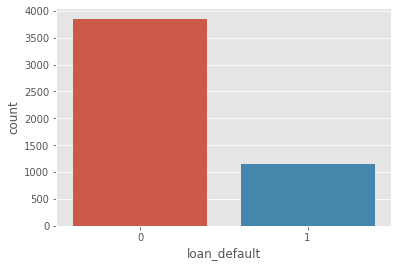

In [ ]:
sns.countplot(Data.loan_default)

Se observa que más del 20% de las deudas no se pagan.

#### 1.2 

Plot a histogram of the annual incomes.

**Answer:**

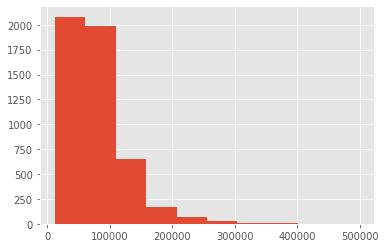

In [ ]:
Data.annual_inc.hist()

Los ingresos anuales de las mayoría de los prestamistas son inferiores a 150.000 dólares.

#### 1.3

Is the distribution of annual incomes different between applicants who defaulted vs. applicants who did not default on their loans?

**Answer:**

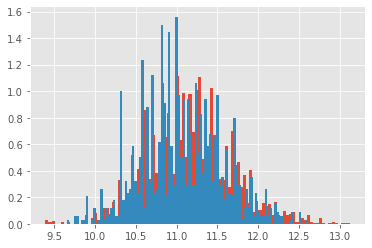

In [ ]:
np.log(Data.annual_inc[Data.loan_default == 0]).hist(bins=100, density=True)
np.log(Data.annual_inc[Data.loan_default == 1]).hist(bins=100, density=True)

We can see that the distributions are not that different, indicating that income alone is not likely to explain a significant fraction of the difference in loan default status.

#### 1.4

Explore the association between annual income and the monthly installment.

**Answer:**

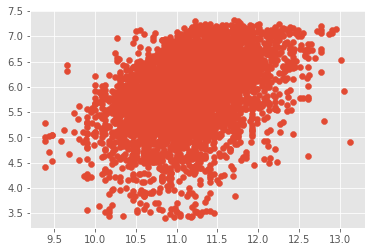

In [ ]:
plt.scatter(np.log(Data.annual_inc), np.log(Data.installment))

Se visualiza una pequeña relación lineal a escala logarítimica entre los ingresos y el pago mensual del préstamo.

__________

Here are a few more figures which look at the relationship between other numerical covariates and the probability of default, as well as annual income:

`emp_length`:

Text(0.5, 1.0, 'Default probability vs. Employment length')

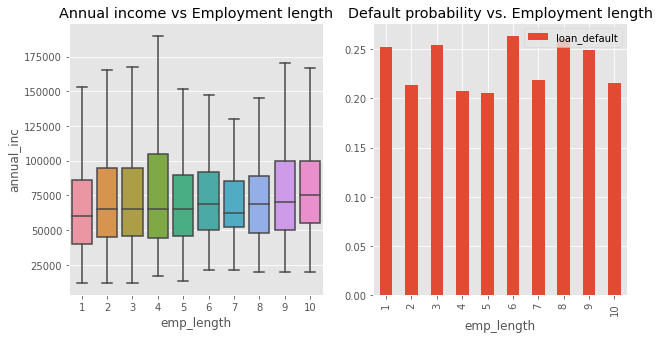

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Annual income vs Employment length")
Data[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. Employment length")

Con el diagrama de cajas y bigotes se observa que la experiencia laboral de los prestamistas no diferencia los ingresos obtenidos entre los mismos, es decir, mayor experiencia laboral no significa mayores ingresos. Además, no se observa una relación clara entre la probabilidad de no pagar la deuda y la experiencia laboral ya que las diferencias entre las probabilidades mínimas y máximas son de al menos el 5%.

`homeOwnership`:

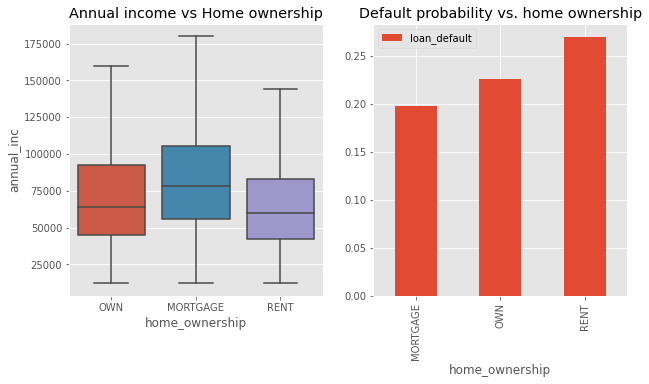

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Annual income vs Home ownership")
Data[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

De la primera gráfica inferimos que en promedio los prestamistas con hipotecas tienen mayores ingresos anuales que los propietarios de viviendas y aquellos que rentan. Además, de la segunda gráfica se puede concluir que las personas que pagan renta tienen mayor probabilidad de no pagar sus deudas en comparación a los otros prestamistas con propiedad o hipoteca.

Here are some figures that show the relationship between various categorical variables and the probability of default:

`purpose`:

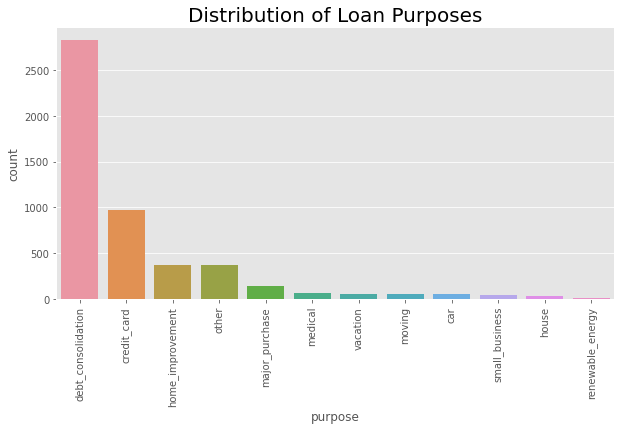

In [ ]:
plt.figure(figsize= (10,5))
Data.emp_length.value_counts()
sns.countplot(x='purpose', order=Data['purpose'].value_counts().index, data = Data) 
plt.xticks(rotation=90)
plt.title("Distribution of Loan Purposes", fontsize=20);

Se observa que la mayor proporción de los créditos son destinados a compra y consolidación de cartera, tarjetas de crédito y mejoras de vivienda.

Text(0.5, 1.0, 'Default Probability by Loan Purpose')

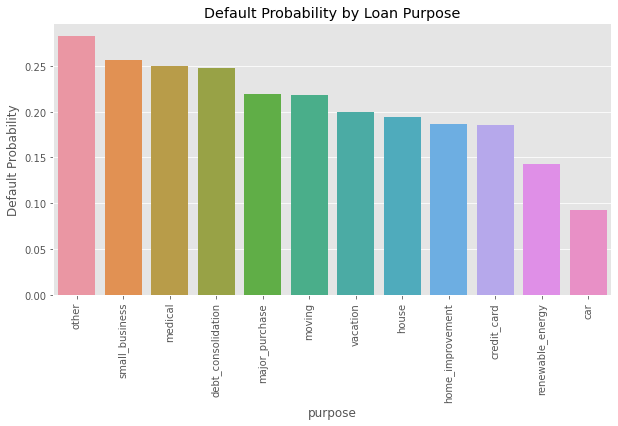

In [ ]:
plt.figure(figsize= (10,5))
purpose_default = Data[["loan_default", "purpose"]].groupby("purpose").mean()
purpose_default = purpose_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=purpose_default.index[:30], 
            y=purpose_default["loan_default"][:30].values,
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Default Probability");
plt.title("Default Probability by Loan Purpose")


Se observa en la gráfica anterior que la probabilidad de no pago de deudas sin caracterizar sumadas contribuyen en mayor cantidad que las deudas no pagadas por otros conceptos, a estas le siguen los no pagos a deudas de pequeños negocios, gastos médicos y compra - consolidación de cartera.

`job`:

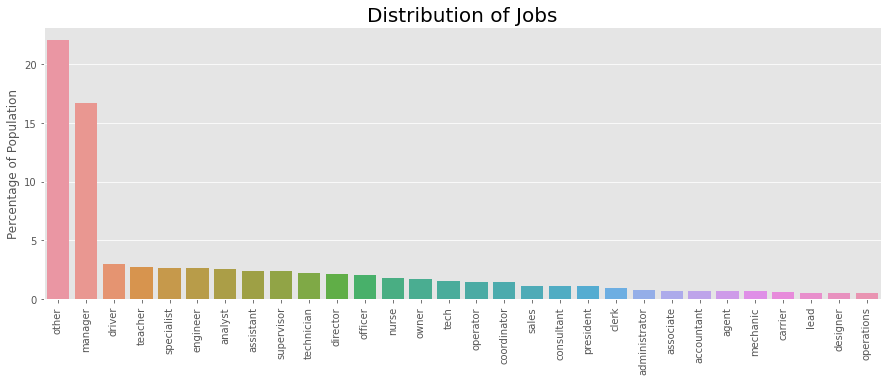

In [ ]:
plt.figure(figsize= (15,5))
sns.barplot(x=Data["job"].value_counts()[:30].index.values , 
            y=100 * Data.job.value_counts()[:30].values / len(Data),
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs", fontsize=20);


Comparando entre los diferentes cargos de los prestamistas aquellos que tienen oficios administrativos aquieren la mayor cantidad de deudas en este banco.

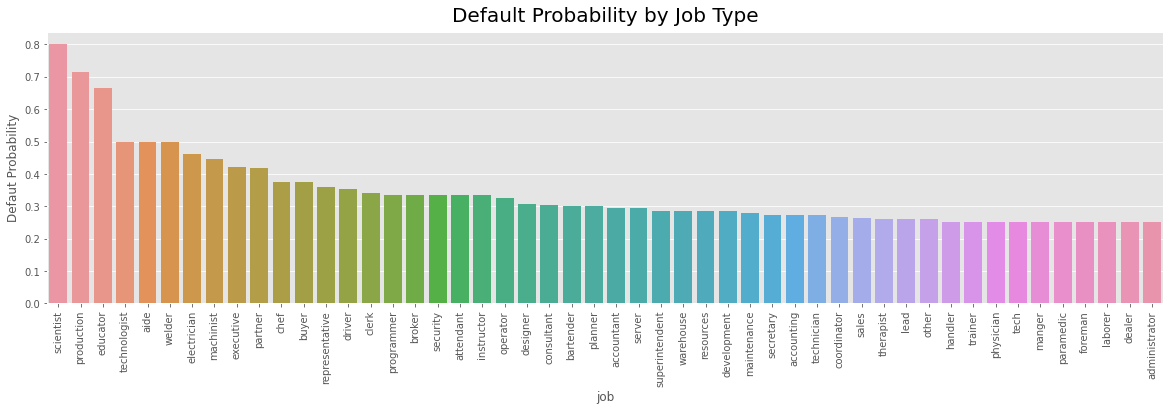

In [ ]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Probability by Job Type", fontsize=20, verticalalignment='bottom');

La mayoría de las profesiones de los prestasmistas tienen probabilidad de impago entre el 25% y el 50%. Por otro lado, las profesiones con esta probabilidad mayor al 50% son educador, producción y científico con el 68%, 71% y 80% respectivamente.

### Adding a new variable

The yearly payment owed by the borrower, as a fraction of their annual income, is a standard metric used in evaluating whether a loan should be issued. Let's define a new variable **"install_income"** which codes the installment as a fraction of the annual income and study its association with the other features:

Text(0.5, 0, 'Installment / Income')

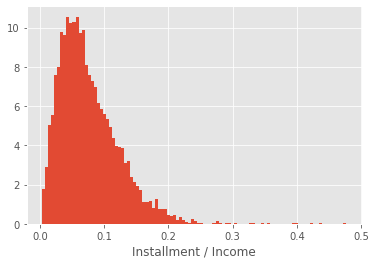

In [ ]:
Data['install_income'] = 12 * Data.installment / Data.annual_inc
H = plt.hist(Data['install_income'], bins=100, density=True)
plt.xlabel(r"Installment / Income")

Se observa que los prestamistas destinan máximo el 20% de sus ingresos anuales en el pago mensual de la cuota del crédito.

In order to easily investigate this variable's association with the probability of default, define a new covariate named `install_income_disc` that is a discretized version of `install_income`:

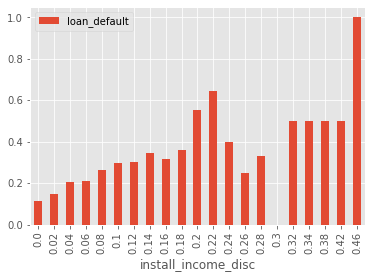

In [ ]:
# let us discretize the "install_income" variable to study the probability of default 
# as a function of "install_income"
Data["install_income_disc"] = (Data.install_income*50).astype(int)/50.  #discretization
Data[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
Data = Data.drop(["install_income_disc"], axis=1)

# --> there is a clear positive association: as the fraction of the annual income devoted to the re-imbursement of 
# the loan increases, the probability of default sharply increases

La gráfica anterior muestra la relación de no pago y la proporción de la cuota respecto al salario del prestamista, a mayor proporción de pago mensual mayor probabilidad de no pago.

### Exercise 2: (10 mts)

Visualize the correlation matrix across all numerical features by using the `sns.heatmap()` command

**Answer:**

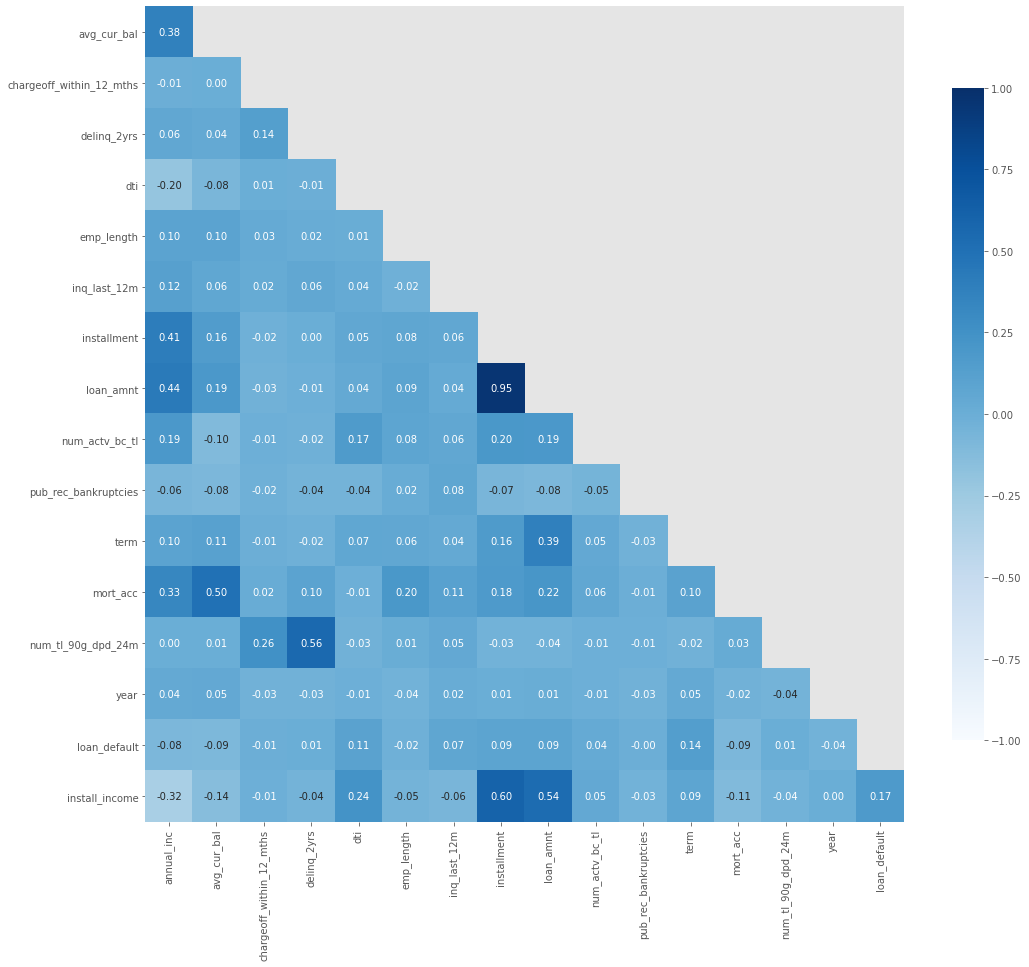

In [ ]:
#compute correlation matrix
labels = ['application_type', 'grade', 'purpose', 'job', 'home_ownership']# drop rows
# get correlations
df_corr = Data.corr()# irrelevant fields
df_corr

#mask the upper half for visualization purposes
np.ones_like(df_corr, dtype=np.bool)

fig, ax = plt.subplots(figsize=(17, 15))# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})# yticks
plt.yticks(rotation=0)

# Draw the heatmap with the mask and correct aspect ratio
plt.show()

## Building a predictive model (20 mts)

Let's first start by building a standard logistic regression model. In general, it is important and extremely useful to first create baseline/simple models which can be compared to more complex models later.

### Exercise 3: (15 mts)

#### 3.1

Using the `LogisticRegression()` function from `scikit-learn`, write a function named `fit_logistic_regression(X,y)` that fits a logistic regression on the array of covariates `X` and associated response variable `y`.

**Answer:**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# import the metrics class
from sklearn.metrics import accuracy_score, recall_score, f1_score


def fit_logistic_regression(X, y, split):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()

    # fit the model with data
    logreg.fit(X_train, y_train)
    
    #
    y_pred = logreg.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    return np.array(y_test), y_pred

#### 3.2

Create a basic logistic regression model for predicting the loan default with only one feature: `install_income`.  Call this model `model1`. Use a 70/30 train-test split of the data.

**Answer:**

In [ ]:
X = Data[['install_income']] # Features
y = Data.loan_default

y_test, y_pred = fit_logistic_regression(X, y, split=0.3)

Accuracy: 0.776
Recall: 0.005934718100890208
F1 Score: 0.011764705882352941


#### 3.3

Plot the ROC curve of `model1` and find the area under the curve.

**Answer:**

AUC ROC
0.5025374364365156
------------------------------------------------------


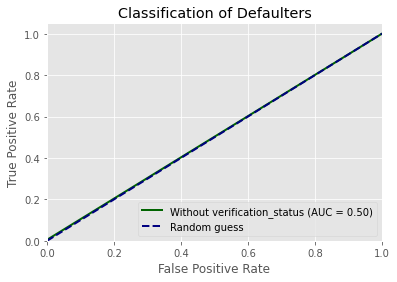

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def plot_roc(y, y_pred):
    # función para pintar la curva ROC y mostrar el AUC
    roc_novs = roc_curve(y, y_pred) # .cat.codes
    auc_novs = auc(roc_novs[0], roc_novs[1])
    print('AUC ROC')
    print(auc_novs)
    print('------------------------------------------------------')

    plt.figure()
    lw = 2

    plt.plot(roc_novs[0], roc_novs[1], color='darkgreen',
    lw=lw, label='Without verification_status (AUC = %0.2f)' % auc_novs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Classification of Defaulters')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(pd.DataFrame(y_test).iloc[:,0].astype(int).tolist(), pd.DataFrame(y_pred).iloc[:,0].astype(int).tolist())


### Exercise 4: (5 mts)

#### 4.1

Consider `model1` from above. Would you want this to be your final model? Why or why not?

**Answer:**

Sí, ya que la exactitud del modelo es de 75% aproximadamente y por el principio de la parsimonia sería un modelo adecuado.

#### 4.2

Let's instead put all the variables available in the model, so that we are maximally leveraging our available info. Would you be in favor of this or not?

In [ ]:
X = Data.drop(columns=['loan_default','application_type', 'grade', 'purpose', 'job', 'home_ownership']) # Features
y = Data.loan_default

y_test, y_pred = fit_logistic_regression(X,y,split = 0.3)

Accuracy: 0.7766666666666666


**Answer:**

Se concluye que añadir todas las variables al modelo no tiene mucho sentido, ya que la diferencia en la exactitud es de aproximadamente el 1% y agregar todas las variables podría sobreajustar el modelo.

## Cross-validation (30 mts)

**Cross-validation** is a set of techniques for assessing how well the results of a model will generalize to an out-of-sample dataset; i.e. in practice or production. It is chiefly used to flag overfitting.

Cross-validation works as follows: one splits the available data into $k$ sets, or **folds**. $k - 1$ of these folds will be used to train the model, while the held-out fold will be used as the test set on which the model is evaluated. For computational stability, this procedure is generally split many times, such that each fold has an opportunity to serve as the test set. For each repetition, a metric of prediction performance (e.g. AUC) is calculated on the test set. The average of these metrics, as well as their standard deviation, is then reported. An example is shown here for 5-fold cross-validation:

![](cv_fig.png)

Let's do this with code. The following code displays the 5 different folds used in a standard 5-fold cross-validation approach. To do so, use the `StratifiedKFold()` function from `scikit-learn`:

Text(0.5, 1.0, 'CROSS VALIDATION FOLDS')

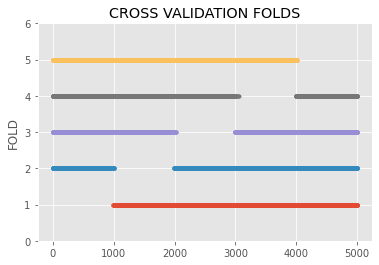

In [ ]:
skf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,6)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

The following code defines a function `compute_AUC(X, y, train_index, test_index)` that computes the AUC of a model trained on "train_index" and tested in "test_index".

In [ ]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train, split=0.3)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

### Exercise 5: (5 mts)

With the help of the `compute_AUC` function defined above, write a function `cross_validation_AUC(X,y,nfold)` that carries out a 10-fold cross-validation and returns a list which contains the area under the curve for each fold of the cross-validation.

**Answer:**

In [ ]:
from scipy import mean
def cross_validation_AUC(X,y,nfold):
    AUC = []
    skf = StratifiedKFold(n_splits=nfold)
    for train_index, test_index in skf.split(X, y) :
        auc_score, fpr, tpr = compute_AUC(X, y, train_index, test_index)
        AUC.append(auc_score)
    auc_listas = AUC   
    return auc_listas

In [ ]:
X = Data[['install_income']] # Features
y = Data.loan_default
lista_1 = cross_validation_AUC(X, y, nfold = 10)

In [ ]:
X = Data.drop(columns=['loan_default','application_type', 'grade', 'purpose', 'job', 'home_ownership']) # Features
y = Data.loan_default
lista_2 =cross_validation_AUC(X, y, nfold = 10)

__________

We will now estimate and compare, through cross-validation analysis, the performance of all the "simple models" that only use one numerical feature as input. As discussed in the EDA section, we will use the logarithmic transform for the `anual_income`, `loan_amount`, and `avg_cur_bal` variables:

In [ ]:
# let us extract only the numerical (i.e non-categorical) features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = Data.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["installment", "year"], axis=1)

# Using a log scale when appropriate
Data_numerics["annual_inc"] = np.log10(Data_numerics["annual_inc"])
Data_numerics["loan_amnt"] = np.log10(Data_numerics["loan_amnt"])
Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])

Let's compute cross-validation estimates of the AUC for each single-feature model:

In [ ]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in Data_numerics.keys():
    if key == "loan_default": continue
    X_full, y_full = Data_numerics[[key]], Data_numerics.loan_default
    auc_list = cross_validation_AUC(X_full, y_full, nfold=10)
    model_perf["SIMPLE:" + key] = auc_list

In [ ]:
model_perf

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income
0,0.554410,0.542259,0.494783,0.501942,0.573698,0.537041,0.590830,0.567871,0.509689,0.467544,0.560926,0.548797,0.512456,0.621604
1,0.573744,0.568978,0.499142,0.478848,0.578566,0.530627,0.535325,0.607566,0.589080,0.488379,0.580407,0.599481,0.484404,0.661683
2,0.564472,0.575065,0.501750,0.508187,0.580305,0.546990,0.499435,0.499718,0.542823,0.515460,0.546527,0.579944,0.517527,0.564438
3,0.577538,0.526606,0.498701,0.507149,0.598125,0.518758,0.514850,0.554274,0.506200,0.497470,0.569565,0.536036,0.495099,0.639097
4,0.584190,0.584822,0.503049,0.486358,0.570695,0.496454,0.585251,0.567781,0.525409,0.487081,0.563523,0.578701,0.487250,0.664009
5,0.568786,0.532038,0.500452,0.458893,0.568504,0.555855,0.516194,0.529091,0.532829,0.505759,0.545737,0.548063,0.494241,0.582101
6,0.523343,0.544370,0.495257,0.503185,0.563467,0.490785,0.593586,0.563840,0.512851,0.507679,0.612196,0.558521,0.513676,0.586155
7,0.564710,0.573005,0.494819,0.475559,0.536815,0.492739,0.531963,0.553586,0.485320,0.502432,0.604400,0.538917,0.474889,0.596696
8,0.549257,0.518555,0.496114,0.549484,0.596809,0.494512,0.559108,0.584504,0.521453,0.516635,0.583174,0.545144,0.517328,0.637806
9,0.525248,0.560131,0.504863,0.529747,0.572391,0.480649,0.539156,0.574720,0.530656,0.486149,0.548087,0.577470,0.518873,0.602070


### Exercise 6: (5 mts)

Construct a boxplot which shows the distribution of cross-validation scores of each variable (remember, each variable has 10 total scores). Which feature has the highest/lowest predictive power?

**Answer:**

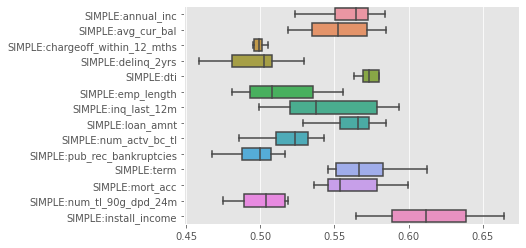

In [ ]:
sns.boxplot(data = model_perf,  orient="h" ,showfliers=False)

La mejor variable predictora sería la proporción del ingreso neto anual que es destinado al pago de la cuota del crédito (install_income) y la peor variable para predecir el impago es el número de veces que una persona se atraza en mas de 30 días para el pago de sus obligaciones de los últimos 2 años (delinq_2yrs).

### Exercise 7: (5 mts)

Consider the model that consists of using *all* the numerical features (and none of the categorical features). Carry out a 10-fold cross-validation analysis to determine whether this model has better predictive performance than the best single-feature model. Use the boxplot method again as we did in Exercise 7.

**Answer:**

[0.6716431394692264, 0.7152343308865049, 0.6423941276115188, 0.6683229813664596, 0.7050028232636929, 0.5804404291360813, 0.6765894974590627, 0.6467593855104081, 0.6659167348422871, 0.674484137805654]


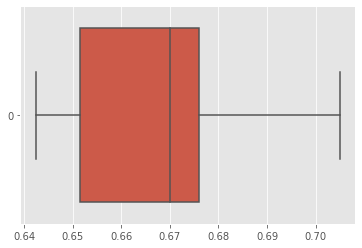

In [ ]:
X = Data.drop(columns=['loan_default','application_type', 'grade', 'purpose', 'job', 'home_ownership']) # Features
y = Data.loan_default
lista_2 = cross_validation_AUC(X, y, nfold = 10)
print(lista_2)
sns.boxplot(data = lista_2,  orient="h" ,showfliers=False)

De acuerdo al gráfico anterior, podemos concluir que hay una leve mejora en la efectividad del modelo, solo tomando las variables numéricas.

## Incorporating categorical variables (25 mts)

The grade of a loan (i.e. the LC-assigned loan grade feature) has not been used so far. The following is the distribution of the categorical grade feature:

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

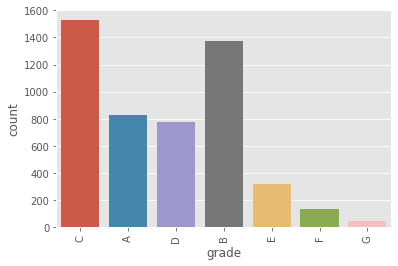

In [ ]:
Data.emp_length.value_counts()
sns.countplot(x='grade', data = Data) 
plt.xticks(rotation=90)

### Exercise 8: (5 mts)

#### 8.1

Use `pandas.get_dummies()` to transform this into its one-hot encoded version.

**Answer:**

In [ ]:
cols = ['application_type', 'grade', 'purpose', 'job', 'home_ownership'] 
Data_dum = pd.get_dummies(data = Data,columns=cols)
Data_dum

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,year,loan_default,install_income,application_type_Individual,application_type_Joint App,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,job_accountant,job_accounting,...,job_planner,job_practitioner,job_president,job_principal,job_processor,job_production,job_professor,job_programmer,job_realtor,job_receptionist,job_recruiter,job_representative,job_resources,job_sales,job_scientist,job_secretary,job_security,job_sergeant,job_server,job_service,job_services,job_specialist,job_superintendent,job_supervisor,job_support,job_teacher,job_tech,job_technician,job_technologist,job_teller,job_therapist,job_trainer,job_underwriter,job_vp,job_warehouse,job_welder,job_worker,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
2790,38000.0,2375.0,0.0,0.0,12.19,1,1.0,601.36,17100,5.0,0.0,36,0.0,0.0,2017,1,0.189903,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1822,55000.0,20371.0,0.0,0.0,21.19,1,1.0,586.45,17500,4.0,0.0,36,2.0,0.0,2017,0,0.127953,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2857,45000.0,2437.0,0.0,0.0,17.09,10,0.0,308.64,10000,2.0,0.0,36,0.0,0.0,2016,0,0.082304,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4776,125000.0,10340.0,0.0,2.0,14.10,1,4.0,874.93,35000,2.0,0.0,60,3.0,0.0,2015,0,0.083993,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4482,70000.0,2089.0,0.0,0.0,9.12,3,0.0,848.27,25000,4.0,0.0,36,0.0,0.0,2017,0,0.145418,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3528,260000.0,38359.0,0.0,0.0,4.54,10,4.0,1153.67,35000,7.0,0.0,36,1.0,0.0,2016,0,0.053246,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3722,90000.0,31537.0,0.0,0.0,18.27,6,1.0,743.90,22400,7.0,1.0,36,1.0,0.0,2017,0,0.099187,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4405,68000.0,1849.0,0.0,0.0,17.00,9,3.0,712.96,20000,4.0,1.0,36,0.0,0.0,2016,0,0.125816,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3968,68500.0,17577.0,0.0,0.0,27.45,3,6.0,978.27,32875,6.0,0.0,60,1.0,0.0,2016,1,0.171376,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### 8.2

Add this feature to the all-numerical model from earlier and investigate whether this leads to a significant increase in predictive accuracy.

In [ ]:
X = Data_dum.drop(columns=['loan_default']) # Features
y = Data_dum.loan_default
y_test, y_pred = fit_logistic_regression(X, y, split=0.3)

Accuracy: 0.7766666666666666
Recall: 0.06824925816023739
F1 Score: 0.12073490813648292


No se presenta una mejora significativa en el Accuracy agregando  las variables dummies al modelo.

**Answer:**

### Exercise 9: (15 mts)

Investigate whether the categorical variable `job` brings any predictive value when added to the current best model. Again, you may want to use a one-hot encoding scheme.

**Answer:**

In [ ]:
cols = ['loan_default','application_type', 'grade', 'purpose', 'home_ownership']
Data_dum_2 = pd.get_dummies(data = Data,columns=['job']) 
X = Data_dum_2.drop(columns=cols)
y =  Data_dum_2.loan_default
y_test, y_pred = fit_logistic_regression(X,y,split = 0.3)

Accuracy: 0.7766666666666666
Recall: 0.06824925816023739
F1 Score: 0.12073490813648292


No se presenta ninguna mejora estadisticamente significativa en modelo.

## Conclusions (5 mts)

In this case, we first explored the loan dataset and found the single-variable associations between the available features and the default rate. We also discovered which features required transformations (e.g. log transform).

Once we started building models, we started with very simple logistic regressions approaches – these baseline models were useful for quickly evaluating the predictive power of each individual variable. Next, we employed cross-validation approaches for building more complex models, often exploiting the interactions between the different features. Since the loan dataset contains a large number of covariates, using cross-validation was revealed to be crucial for avoiding overfitting, choosing the correct number of features and ultimately choosing an appropriate model that balanced complexity with accuracy.

## Takeaways (5 mts)

Cross-validation is a robust and flexible technique for evaluating the predictive performance of statistical models. It is especially useful in big data settings where the number of features is large compared to the number of observations. When used appropriately, cross-validation is a powerful method for choosing a model with the correct complexity and best predictive performance.